### Nonnegative Matrix Factorization 

The Why and How of Nonnegative Matrix Factorization - download: https://arxiv.org/pdf/1401.5226.pdf

Por quê usar NMF?
- Extrai fatores esparsos e facilmente interpretáveis.

## NMF em modelagem de tópicos
![](nmf.png)
Fonte: [Paper]( https://arxiv.org/pdf/1401.5226.pdf)
![](nmf_topic_modeling.png)
Fonte: [NMF tutorial]( https://perso.telecom-paristech.fr/essid/teach/NMF_tutorial_ICME-2014.pdf)

### Passos para fatorar
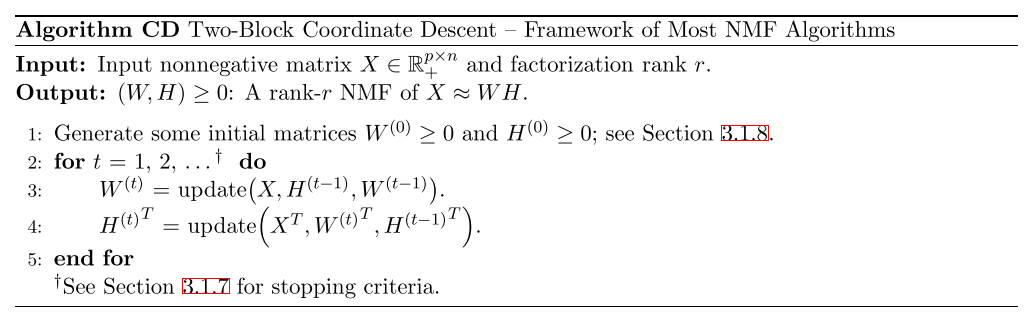

- W e H iniciam de forma randômica
- Atualiza-se W e H
    ![](w_h_form.png)
- Calcula-se o erro, minimizando a função:
     ![](erro.png)
     
- NMF is NP-hard
 - Heuristicas são usadas - conververgência em pontos locais (provado ser boas técnicas em muitas aplicações)
- Escolha do número de tópicos
    - tentativa e erro
    - estimação usando SVD
    - uso de especialistas

### Criando  NMF

- Entender como a fatoração é feita

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re

In [2]:
def NMF(V, k):
    #obter o tamanho da matriz
    n, m = V.shape
    
    #ninicializar de forma randômica
    W = np.random.rand(n,k)
    H = np.random.rand(k,m)
    
    #inicializar o erro
    erro = 1
    err = 1
    
    #loop para aproximação das matrizes da matriz real - otimização
    while err > 1e-04:
        old_error = erro
        
        #valores para atualizar matriz H
        h_numerador = np.dot(W.T, V)
        h_denominador = np.dot(W.T, np.dot(W, H))
        H = H*(h_numerador/h_denominador)
        
        #valores para atualizar matriz W
        w_numerador = np.dot(V, H.T)
        w_denominador = np.dot(W, np.dot(H, H.T))
        W = W* (w_numerador/w_denominador)
        
        #calcular o erro 
        error = np.sum(np.power(V - np.dot(W, H), 2))
        err = np.abs(old_error - erro)
        
    return W, H, error

###  Carregar base preprocessada aula 1

In [3]:
dataset = pd.read_csv('data/preprocessed_data.csv', sep=';')
dataset.head(-1)
dataset.clean_text[0]

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline shortterm interest rates on smalldenomination consumer cds sold directly banks average yield sixmonth deposits fell 549 562 week ended yesterday according 18bank survey banxquote money markets wilmington del information service on threemonth consumer deposits average yield sank 529 542 week according banxquote two banks banxquote survey citibank new york corestates pennsylvania paying less 5 threemonth smalldenomination cds declines somewhat smaller fiveyear consumer cds eased 737 745 banxquote said yields threemonth sixmonth treasury bills sold mondays auction plummeted fifth percentage point previous week 546 563 respectively'

In [4]:
def remove_numbers(text):
    text = re.sub(r'[0-9]+', '', text)
    
    return text

dataset['clean_text'] = dataset['clean_text'].apply(remove_numbers)
dataset['clean_text'][0]

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline shortterm interest rates on smalldenomination consumer cds sold directly banks average yield sixmonth deposits fell   week ended yesterday according bank survey banxquote money markets wilmington del information service on threemonth consumer deposits average yield sank   week according banxquote two banks banxquote survey citibank new york corestates pennsylvania paying less  threemonth smalldenomination cds declines somewhat smaller fiveyear consumer cds eased   banxquote said yields threemonth sixmonth treasury bills sold mondays auction plummeted fifth percentage point previous week   respectively'

### Vetorização dos dados term-document-matrix 

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))
data1 = vectorizer.fit_transform(dataset.clean_text)
# O resultado é um dataset de documentos por palavras (features)
data1.shape


(1420, 112429)

In [6]:
# O algoritimo precisa ser invertido para palavras por documentos (pivotar)
data = data1.toarray()
data = data.T
data.shape

(112429, 1420)

### Verificar decaimento do erro de diferentes números de tópicos

In [ ]:
erro = []

for n_topics in range(2, 100+1):
    W, H, err = NMF(data, n_topics)
    if n_topics % 10 == 0:
        print(n_topics, err)
    erro.append(err)

10 1415.5226846404412


In [ ]:
#plotar o erro
plt.plot(range(2, 100+1), erro)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('Non-Negative Matrix Factorization')

In [ ]:
#computar NMF com 3 tópicos
W, H, err = NMF(data, 3)

In [ ]:
W.shape, H.shape

In [ ]:
#função de visualização das palavras mais significativas
def words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key = lambda x:x[1], reverse = True)
    
    return doc_list

In [ ]:
#top 10 palavras do topico 1
topic_words = words(W[:,0], vectorizer.get_feature_names())
for word, weight in topic_words[:10]:
    print(word, weight)

In [ ]:
#top 10 palavras do topico 2
topic_words = words(W[:,1], vectorizer.get_feature_names())
for word, weight in topic_words[:10]:
    print(word, weight)

In [ ]:
#top 10 palavras do topico 13
topic_words = words(W[:,2], vectorizer.get_feature_names())
for word, weight in topic_words[:10]:
    print(word, weight)

### Visualizar matrizes W e H

In [ ]:
#matriz W - palavras por tópico, ordenando por mais importantes
vocab = vectorizer.get_feature_names()
pd.DataFrame(W, columns=['topic1', 'topic2', 'topic3'], index=vocab).sort_values(by=['topic3'], ascending=False)

In [ ]:
#matriz H - topicos por documentos, 
pd.DataFrame(H)

### Aplicando scikit-learn 

[NMF scikit-learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

Data [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews) includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews


In [461]:
!pip install unidecode
from bs4 import BeautifulSoup
import string 
from unidecode import unidecode 
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')
from sklearn import decomposition


def clean_html(text):
    soup = BeautifulSoup(text, 'html')
    for s in soup(['script', 'style']):
        s.decompose()

    return "".join(soup.stripped_strings)


def remove_punctuation(text):
    
    text = [word for word in text if word not in string.punctuation]
    text = ''.join(text)
    
    return text

def remove_stopwords(text):
    text = unidecode(text)
    text = [word.lower() for word in text.split() if word.lower() not in stopwords]
    
    return " ".join(text)

In [462]:
reviews_datasets = pd.read_csv('data/reviews.csv')
print(reviews_datasets.columns)

data = pd.DataFrame()
data['text'] = reviews_datasets['Text'].head(10000)
del reviews_datasets
data.shape

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


(10000, 1)

In [463]:
data['clean_text'] = data['text'].apply(clean_html)
data['clean_text'] = data['clean_text'].apply(remove_punctuation)
data['clean_text'] = data['clean_text'].apply(remove_stopwords)
data['clean_text']

0       bought several vitality canned dog food produc...
1       product arrived labeled jumbo salted peanutsth...
2       confection around centuries light pillowy citr...
3       looking secret ingredient robitussin believe f...
4       great taffy great price wide assortment yummy ...
                              ...                        
9995    switched advance similac organic product think...
9996    like bad reviews say organic formula constipat...
9997    wanted solely breastfeed unable keep supplemen...
9998    love fact get delieved house delievy chargeit ...
9999    7 week old gas constipation problems first 5 w...
Name: clean_text, Length: 10000, dtype: object

In [464]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data.clean_text)
dtm

<10000x11065 sparse matrix of type '<class 'numpy.float64'>'
	with 273681 stored elements in Compressed Sparse Row format>

In [465]:
num_top_words=5
vocab = vectorizer.get_feature_names()

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in t.argsort()[::-1][:10]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]


clf = decomposition.NMF(n_components=5, random_state=1)
W1 = clf.fit_transform(dtm)
H1 = clf.components_

show_topics(H1)

['product great good food love like price chocolate best dog',
 'coffee cup flavor kcups roast like strong taste bold smooth',
 'tea green iced teas love bags flavor drink water like',
 'chips salt potato bag flavor kettle vinegar flavors bags great',
 'juice orange drink soda sugar like taste tangerine switch carbonated']

In [466]:
pd.DataFrame(H1, columns=vocab, index=['topic1', 'topic2', 'topic3', 'topic4', 'topic5']).sort_values(by='topic2', ascending=False, axis=1)

,coffee,cup,flavor,kcups,roast,like,strong,taste,bold,smooth,flavored,good,coffees,wolfgang,bitter,decaf,medium,keurig,great,blend,dark,puck,kcup,cups,favorite,weak,hazelnut,morning,best,tried,nice,brew,rich,french,love,ive,starbucks,vanilla,aroma,use,pods,mountain,try,maker,really,recommend,breakfast,buy,coconut,drink,...,harney,harmony,harmless,harm,hello,harina,hardy,hardware,hardtofind,hardest,hardened,harden,hardcrunchy,harbors,harbor,happymunchies,happyi,happybaby,heads,heal,health,healthconscious,helli,hell,held,heirloom,heinz,height,hehe,hefty,hectic,heck,heavyhanded,heavyduty,heavier,heaventhe,heating,heat,hearts,heartily,heartburn,hears,healty,healthythe,healthyi,healthy,healthiest,healthier,healthful,zukes
topic1,0.000000,0.060903,0.244370,0.057856,0.000000,0.580385,0.013268,0.369157,0.000000,0.005630,0.000000,0.810860,0.007290,0.00000,0.000000,0.000000,0.00000,0.065950,0.826390,0.003408,0.086588,0.000000,0.055840,0.071644,0.166920,0.000000,0.007310,0.047468,0.504480,0.389746,0.130860,0.000000,0.043623,0.004945,0.639274,0.343420,0.000000,0.132283,0.005408,0.443883,0.000817,0.000000,0.279294,0.012312,0.474120,0.244234,0.066672,0.464923,0.049866,0.000000,...,0.000209,0.029237,0.000318,0.002814,0.002905,0.001416,0.001758,0.003894,0.000939,0.005009,0.000410,0.001655,0.001973,0.001656,0.006947,0.001267,0.003635,0.002080,0.011123,0.002052,0.086123,0.000702,0.000915,0.018079,0.006149,0.002837,0.004049,0.002033,0.001756,0.002454,0.001221,0.009305,0.001652,0.000004,0.003533,0.000362,0.003995,0.060670,0.003369,0.002138,0.002345,0.001542,0.001876,0.000467,0.000130,0.178555,0.004449,0.025960,0.000178,0.01809
topic2,2.508719,0.665771,0.410095,0.341154,0.336803,0.334983,0.327917,0.313330,0.311462,0.295986,0.292194,0.267137,0.255220,0.25401,0.250588,0.247732,0.24716,0.237324,0.230705,0.227954,0.224676,0.223756,0.220010,0.218924,0.215342,0.173961,0.172843,0.172803,0.171886,0.167545,0.165896,0.158554,0.154793,0.154608,0.147628,0.140636,0.140487,0.137053,0.128269,0.126032,0.124006,0.123953,0.123123,0.120873,0.119439,0.115883,0.113461,0.108307,0.105628,0.104078,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
topic3,0.000000,0.074153,0.166876,0.006119,0.000000,0.143576,0.086249,0.126687,0.000000,0.047905,0.006132,0.112262,0.000000,0.00000,0.058531,0.024197,0.00000,0.008556,0.117925,0.044654,0.000000,0.000000,0.001586,0.031770,0.060228,0.033498,0.000000,0.044196,0.040989,0.058152,0.047825,0.055217,0.004700,0.009176,0.170695,0.072842,0.008830,0.020550,0.051152,0.109673,0.000000,0.013044,0.065560,0.021969,0.066198,0.073194,0.031408,0.039023,0.009247,0.159429,...,0.007271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000765,0.000000,0.000000,0.000000,0.000717,0.001641,0.033104,0.000000,0.000000,0.000000,0.001692,0.000170,0.000000,0.000000,0.000000,0.000000,0.000199,0.000000,0.002481,0.000026,0.000000,0.000000,0.000859,0.005313,0.000000,0.000000,0.018349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004612,0.00000
topic4,0.000000,0.000000,0.340643,0.000000,0.000000,0.222580,0.039033,0.187696,0.001005,0.000000,0.031354,0.168007,0.000519,0.00000,0.001213,0.000000,0.00000,0.000000,0.255970,0.008145,0.000000,0.000000,0.000000,0.000000,0.127374,0.000000,0.004869,0.000000,0.090834,0.063314,0.053249,0.000000,0.006326,0.000218,0.232741,0.070627,0.000000,0.000000,0.003817,0.000000,0.000000,0.000000,0.113955,0.000000,0.100383,0.066832,0.000806,0.092557,0.000000,0.000000,...,0.000000,0.000000,0.001464,0.000000,0.000288,0.000477,0.002714,0.000000,0.000068,0.000819,

In [467]:
pd.DataFrame(W1, columns=['topic1', 'topic2', 'topic3', 'topic4', 'topic5']).sort_values(by=['topic2'], ascending=False).head(20)

,topic1,topic2,topic3,topic4,topic5
5816,0.000000,0.204752,0.000000,0.000000,0.000000
9043,0.000000,0.194180,0.000000,0.007907,0.000000
8334,0.000000,0.194180,0.000000,0.007907,0.000000
3858,0.000000,0.188586,0.000000,0.000000,0.000000
4582,0.000000,0.178807,0.000045,0.002386,0.000643
4549,0.000000,0.177675,0.000000,0.000000,0.009363
5209,0.000000,0.174665,0.000000,0.000000,0.000000
8435,0.011036,0.173768,0.000000,0.024359,0.022588
9144,0.011036,0.173768,0.000000,0.024359,0.022588
7972,0.000000,0.173668,0.000000,0.000000,0.000000


In [468]:
data['clean_text'][5816]

'bought 4 pack coffee based reviews others price lot coffee since drink less 1 pot per day really enjoy flavor put little cream sweetener agave nectar coffee coffee great flavor comes im super picky coffee tell bad coffee definitely good coffee plan keep buying coffee coffee house'

In [469]:
data['clean_text'][9043]

'great flavor makes great cup coffee fine 1 cup coffee feel like much flavored coffee puck captured great flavor coffee'

### Latent Dirichlet Allocation

- Proposto em 2003 por [Blei et al. ](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
- Outros casos de uso
 - Bioinformática
 - Análise automática de harmonia de musica
 - Localization de objetos em imagens

### Suposições da LDA 

- Documentos que tem tópicos similares usam grupos similares de palavras
    - Documentos são distribuições de tópicos
    - Tópicos são distribuições de palavras
![](lda_suposicoes.jpg)
[Fonte](http://nlpx.net/wp/wp-content/uploads/2016/01/LDA_image2.jpg)

![](lda_plate.png)
[Fonte: Paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

alpha =  distribuição de documentos-topics
 - quando alto indica que cada documento contém uma mistura de tópicos
 - quando baixo indica que cada documento contém poucos tópicos

beta = distribuição de topicos-palavras
 - quando alto indica que cada tópico contém uma mistura de muitas palavras
 - quando baixo indica que cada tópico contém poucas palavras

tetha = distribuição de tópicos por documento

z = tópico que é associado a cada palavra

w = palavra

### Como LDA vê o processo de geração de documentos

![](generative_process.png)

- Dado um documento:
    - Escolher o número de palavras daquele documento (N = número de palavras)
    - Escolher uma mistura de tópicos para aquele documento em um conjunto de tópicos, por exemplo: 10% do tópico A, 30% do tópico B, 60% do tópico C
    - Gerar as palavras do documento através
        - Escolher um tópico baseado na distribuição multinomial definida acima
        - Escolher uma palavra baseado na distribuição multinomial do tópico escolhido


Tem-se os tópicos 
 - Animais, Cozinha, Política
- Animais - cato, cachorro, vaca, leão
- Cozinha - fogão, forno, restaurante, gosto
- Política - deputado, senador, presidente, esquerda, direita

- Escolhe-se tamanho do documento - 1000 palavras
- Escolhe-se o tópico baseado em uma mistura - 800 sobre animais e 100 sobre cozinha e 100 sobre política
- Escolhe-se as palavras baseadas nessa distribuição dos tópicos

### Reconhecer  as representações de K tópicos

1. Escolhe-se um número K de tópicos 
2. Associa cada palavra em cada documento a um dos K tópicos (baseado na distribuição Dirichlet)
3. Para cada documento d 
    - para cada palavra naquele documento d
        - assume-se que todos os tópicos associados estão corretos, exceto pelo atual
        - calcula-se duas proporções
            1. proporção de palavras no documento d que estão atualmente associadas ao tópico t
            2. proporção de associações ao tópico t de todos os documentos que tem a palavra w
        - multiplica-se as duas proporções e associa a palavra w um novo tópico baseado nessa probabilidade 

In [470]:
from sklearn.decomposition import LatentDirichletAllocation

LDA1 = LatentDirichletAllocation(n_components=5, random_state=42)
LDA1.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [471]:
def print_topic_words(LDA, vectorizer):
    for i,topic in enumerate(LDA.components_):
        print(f'Top palavras do tópico {i+1}:')
        print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
        print('\n')
print_topic_words(LDA1, vectorizer)

Top palavras do tópico 1:
['eat', 'snack', 'taste', 'flavor', 'salt', 'love', 'good', 'like', 'great', 'chips']


Top palavras do tópico 2:
['best', 'chocolate', 'product', 'cup', 'taste', 'flavor', 'great', 'like', 'good', 'coffee']


Top palavras do tópico 3:
['eat', 'cats', 'old', 'jerky', 'baby', 'dogs', 'loves', 'treats', 'dog', 'food']


Top palavras do tópico 4:
['jelly', 'good', 'taste', 'drink', 'chia', 'soda', 'orange', 'juice', 'seeds', 'popcorn']


Top palavras do tópico 5:
['great', 'juice', 'drink', 'taste', 'sugar', 'good', 'product', 'food', 'like', 'tea']




In [472]:
topic_values = LDA1.transform(dtm)
print(topic_values.shape)

topic_docs = pd.DataFrame(topic_values, columns=['topic1', 'topic2', 'topic3', 'topic4', 'topic5']).sort_values(by=['topic3'], ascending=False)
topic_docs 

(10000, 5)


,topic1,topic2,topic3,topic4,topic5
2342,0.026022,0.026860,0.892657,0.028593,0.025868
2938,0.028407,0.028209,0.886690,0.027894,0.028800
3701,0.028168,0.028298,0.884826,0.028357,0.030350
6447,0.028779,0.029270,0.884209,0.028363,0.029380
4928,0.029740,0.030642,0.883143,0.026193,0.030281
...,...,...,...,...,...
1320,0.018372,0.311987,0.017701,0.017532,0.634408
6045,0.243084,0.175767,0.017575,0.017437,0.546138
2583,0.188092,0.017841,0.017512,0.017271,0.759284
8756,0.246822,0.492086,0.016389,0.015979,0.228724


In [473]:
data['clean_text'][2938]

'dont know science diet referred junk food one higher quality foods market lot new organic natural cat foods healthy pets cracked regardless veterinarian wanted put 2 year old cat prescription food high count crystals urine comparisons science diet mature adult active longevity closest prescription food cats younger one older 10 food seem enjoy graze day indoor cats try best overfeed younger cat issues urine since went food happy'

In [474]:
lda1_results = pd.concat([data, topic_docs],axis=1)
lda1_results

,text,clean_text,topic1,topic2,topic3,topic4,topic5
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0.040098,0.040565,0.299478,0.579142,0.040716
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,0.231404,0.043832,0.636135,0.042617,0.046012
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,0.033582,0.033079,0.032705,0.032107,0.868527
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0.205231,0.042583,0.041912,0.042152,0.668122
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0.058077,0.406484,0.057113,0.056960,0.421366
...,...,...,...,...,...,...,...
9995,we switched from the advance similac to the or...,switched advance similac organic product think...,0.037475,0.210350,0.678754,0.036030,0.037390
9996,"Like the bad reviews say, the organic formula ...",like bad reviews say organic formula constipat...,0.035207,0.035882,0.036101,0.034625,0.858184
9997,I wanted to solely breastfeed but was unable t...,wanted solely breastfeed unable keep supplemen...,0.026506,0.026504,0.027183,0.026008,0.893799
9998,i love the fact that i can get this delieved t...,love fact get delieved house delievy chargeit ...,0.064126,0.742308,0.065159,0.063049,0.065357


In [475]:
LDA2 = LatentDirichletAllocation(n_components=5, random_state=42, doc_topic_prior=1.2)
LDA2.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=1.2,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [476]:
print_topic_words(LDA2, vectorizer)

Top palavras do tópico 1:
['tried', 'flavor', 'love', 'product', 'sweet', 'chips', 'good', 'taste', 'great', 'like']


Top palavras do tópico 2:
['use', 'favorite', 'kcups', 'great', 'cup', 'like', 'flavor', 'chocolate', 'good', 'coffee']


Top palavras do tópico 3:
['really', 'best', 'flavor', 'love', 'tea', 'product', 'taste', 'like', 'great', 'coffee']


Top palavras do tópico 4:
['make', 'product', 'flavor', 'juice', 'love', 'coffee', 'great', 'like', 'taste', 'good']


Top palavras do tópico 5:
['really', 'taste', 'great', 'like', 'flavor', 'dog', 'product', 'good', 'tea', 'food']




In [477]:
topic_values = LDA2.transform(dtm)
print(topic_values.shape)

topic_docs = pd.DataFrame(topic_values, columns=['topic1', 'topic2', 'topic3', 'topic4', 'topic5']).sort_values(by=['topic3'], ascending=False)

lda2_results = pd.concat([data, topic_docs],axis=1)
lda2_results

(10000, 5)


,text,clean_text,topic1,topic2,topic3,topic4,topic5
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0.145754,0.139782,0.347333,0.208987,0.158143
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,0.168482,0.133314,0.326300,0.198935,0.172969
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,0.290025,0.160526,0.159041,0.178964,0.211444
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0.178892,0.138948,0.280072,0.181636,0.220452
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0.169500,0.233241,0.156911,0.182363,0.257985
...,...,...,...,...,...,...,...
9995,we switched from the advance similac to the or...,switched advance similac organic product think...,0.167460,0.144575,0.162559,0.143287,0.382119
9996,"Like the bad reviews say, the organic formula ...",like bad reviews say organic formula constipat...,0.190419,0.146764,0.177405,0.180699,0.304712
9997,I wanted to solely breastfeed but was unable t...,wanted solely breastfeed unable keep supplemen...,0.145796,0.133536,0.163581,0.136517,0.420570
9998,i love the fact that i can get this delieved t...,love fact get delieved house delievy chargeit ...,0.196759,0.195145,0.214213,0.187877,0.206006


### Visualização do LDA com gensim

In [478]:
!pip install pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim import corpora

data_list = [i.split() for i in data.clean_text]

dictionary = corpora.Dictionary(data_list)

In [479]:
# Document Term Matrix 
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_list]

Lda_gensim = gensim.models.ldamodel.LdaModel

ldamodel = Lda_gensim(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10)


In [480]:
for i in ldamodel.print_topics(): 
    for j in i: 
        print(j)

0
0.016*"food" + 0.008*"one" + 0.007*"dog" + 0.007*"like" + 0.006*"good" + 0.006*"eat" + 0.006*"love" + 0.005*"also" + 0.005*"best" + 0.005*"much"
1
0.015*"product" + 0.010*"great" + 0.007*"amazon" + 0.007*"use" + 0.006*"would" + 0.006*"time" + 0.006*"order" + 0.006*"one" + 0.006*"box" + 0.005*"good"
2
0.022*"chips" + 0.011*"snack" + 0.011*"salt" + 0.010*"great" + 0.008*"like" + 0.008*"love" + 0.007*"flavor" + 0.007*"good" + 0.007*"fat" + 0.007*"potato"
3
0.019*"tea" + 0.012*"sugar" + 0.012*"drink" + 0.012*"like" + 0.011*"taste" + 0.011*"juice" + 0.010*"water" + 0.008*"milk" + 0.008*"orange" + 0.008*"flavor"
4
0.033*"coffee" + 0.017*"like" + 0.014*"flavor" + 0.013*"taste" + 0.013*"good" + 0.010*"one" + 0.010*"cup" + 0.007*"great" + 0.007*"tried" + 0.007*"would"


In [481]:
pyLDAvis.enable_notebook()

plot_data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
plot_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.059751  0.082254       1        1  29.836533
0     -0.078845 -0.057619       2        1  23.621140
1     -0.116175 -0.102203       3        1  19.443686
3      0.038733  0.159383       4        1  18.774010
2      0.216038 -0.081814       5        1   8.324621, topic_info=        Term         Freq        Total Category  logprob  loglift
474   coffee  3812.000000  3812.000000  Default  30.0000  30.0000
1192     tea  1397.000000  1397.000000  Default  29.0000  29.0000
6       food  1468.000000  1468.000000  Default  28.0000  28.0000
3064   chips   704.000000   704.000000  Default  27.0000  27.0000
78    flavor  2387.000000  2387.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
386    tasty   120.680817   390.678833   Topic5  -5.5876   1.3112
214    taste   189.434891  2656.259521   Topic5  -5.1367  -0.1547
249   eating   121.194862   429.414764   Topic5  -5.5834   1.2209
183     dont   125.122185  1462.417480   Topic5  -5.5515   0.0274
161     also   119.329071  1331.691650   Topic5  -5.5989   0.0736

[371 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
309       1  0.005648    100
309       2  0.033889    100
309       3  0.115787    100
309       4  0.516807    100
309       5  0.330417    100
...     ...       ...    ...
1185      4  0.033394   year
270       1  0.169807  years
270       2  0.620531  years
270       3  0.096434  years
270       4  0.111109  years

[713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

### Mais referências interessantes para se ler, entender e praticar

[Tutorial scikit-learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

[Modelagem de tópicos e análise de sentimento aplicada no Insight Health Data Science program](https://blog.insightdatascience.com/topic-modeling-and-sentiment-analysis-to-pinpoint-the-perfect-doctor-6a8fdd4a3904)

[Modelagem de tópicos Issu](https://www.youtube.com/watch?v=3mHy4OSyRf0)

[Topic Modeling with SVD & NMF](https://www.youtube.com/watch?v=tG3pUwmGjsc&t=3409s)